# Understanding L1 and L2 Regularization in Logistic Regression (Scikit-learn Tutorial)

**Student Name: ** Sonia Suvarna Dokala
**Module:** Machine Learning Tutorial – Individual Assignment  
**Framework:** Scikit-learn

---

## What this tutorial covers

In this tutorial, I explore how L1 and L2 regularization affect:

* The **model complexity** and feature selection behavior
* The **generalization performance** on unseen data
* The **feature weights** and sparsity patterns

I use a **synthetic binary classification dataset** to demonstrate:

* How **L1 regularization** promotes sparsity by driving some feature weights to zero
* How **L2 regularization** shrinks weights uniformly without eliminating features
* The impact of regularization strength on model performance

I compare the following regularization approaches in Scikit-learn:

* No Regularization (baseline)
* L1 Regularization (Lasso)
* L2 Regularization (Ridge)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
)

sns.set(style="whitegrid", context="notebook", font_scale=1.1)
np.random.seed(42)


In [ ]:
# Binary classification dataset with some informative and redundant features
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    class_sep=1.5,
    flip_y=0.01,
    random_state=42,
)

feature_names = [f"feature_{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,1.625100,1.678124,0.493516,1.290880,-1.114278,1.847020,1.912294,1.357325,0.966041,-3.006921,1
1,-0.064641,4.138629,-1.522415,-2.041705,2.116697,5.281310,3.712587,-0.890254,1.438826,-3.623448,0
2,1.016313,2.665426,-0.628486,-0.886923,0.992518,1.942381,1.855199,-1.958175,-0.348803,-1.598825,0
3,1.037282,1.466618,-0.115420,1.170755,-1.458516,1.371440,1.000965,-1.034471,-1.654176,-2.936285,1
4,0.778385,1.565828,-1.724917,-2.735667,1.215107,1.231249,-0.151824,0.598330,-0.524283,1.252909,0


target
1    0.503
0    0.497
Name: proportion, dtype: float64


/tmp/ipython-input-148860452.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="viridis")


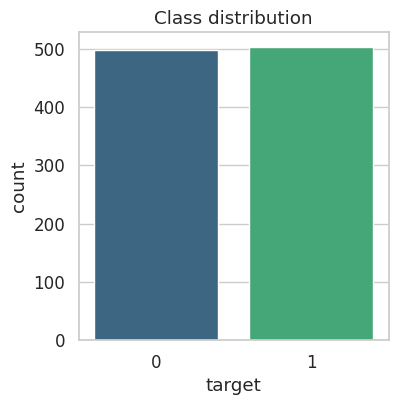

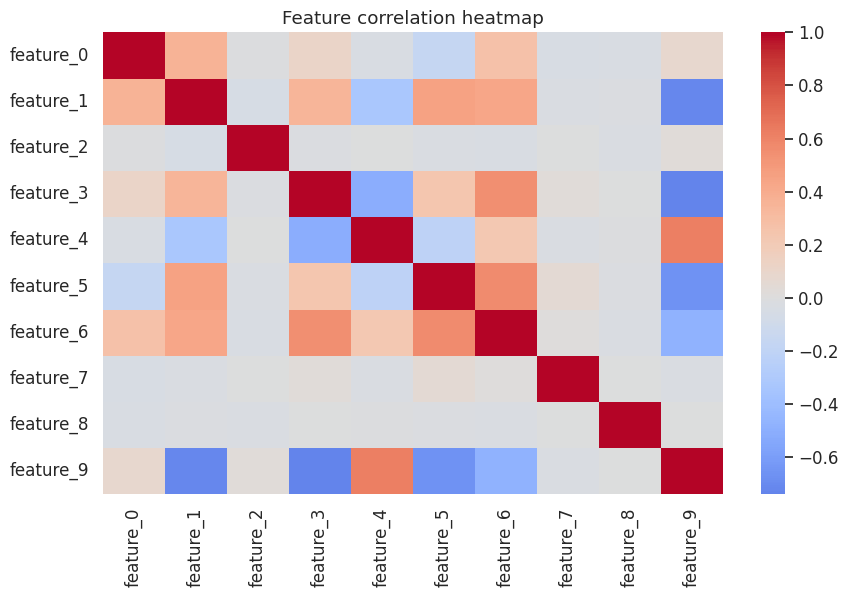

In [ ]:
print(df["target"].value_counts(normalize=True))

plt.figure(figsize=(4, 4))
sns.countplot(x="target", data=df, palette="viridis")
plt.title("Class distribution")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df[feature_names].corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation heatmap")
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names].values,
    df["target"].values,
    test_size=0.2,
    stratify=df["target"].values,
    random_state=42,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Baseline L2 (C=1.0)
Train accuracy: 0.905
Test accuracy: 0.93

Classification report (test):

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        99
           1       0.94      0.92      0.93       101

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



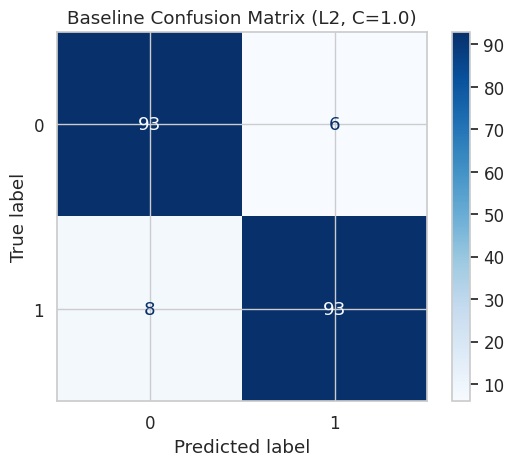

Test ROC-AUC: 0.9741974197419743


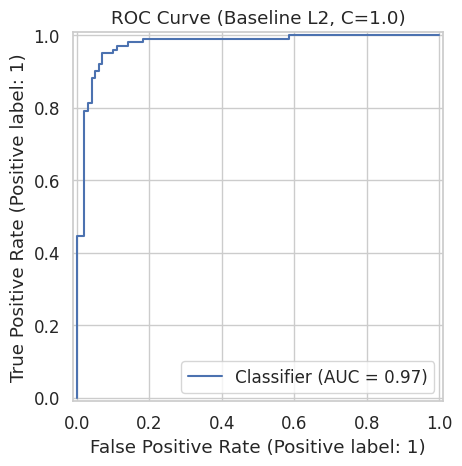

In [ ]:
baseline_clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42,
)
baseline_clf.fit(X_train_scaled, y_train)

y_train_pred = baseline_clf.predict(X_train_scaled)
y_test_pred = baseline_clf.predict(X_test_scaled)
y_test_proba = baseline_clf.predict_proba(X_test_scaled)[:, 1]

print("Baseline L2 (C=1.0)")
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification report (test):\n")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Baseline Confusion Matrix (L2, C=1.0)")
plt.show()

roc_auc = roc_auc_score(y_test, y_test_proba)
print("Test ROC-AUC:", roc_auc)

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve (Baseline L2, C=1.0)")
plt.show()


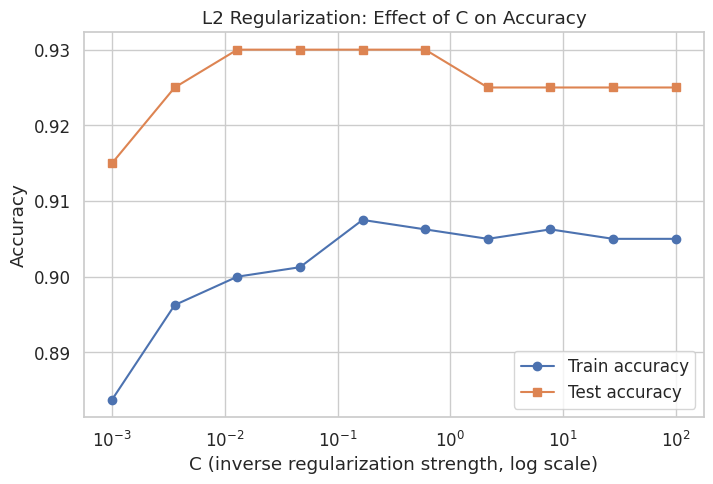

In [ ]:
C_values = np.logspace(-3, 2, 10)  # 0.001 to 100
l2_train_scores = []
l2_test_scores = []
l2_coefs = []

for C in C_values:
    clf_l2 = LogisticRegression(
        penalty="l2",
        C=C,
        solver="lbfgs",
        max_iter=1000,
        random_state=42,
    )
    clf_l2.fit(X_train_scaled, y_train)
    l2_train_scores.append(clf_l2.score(X_train_scaled, y_train))
    l2_test_scores.append(clf_l2.score(X_test_scaled, y_test))
    l2_coefs.append(clf_l2.coef_.ravel())

l2_coefs = np.array(l2_coefs)

plt.figure(figsize=(8, 5))
plt.semilogx(C_values, l2_train_scores, marker="o", label="Train accuracy")
plt.semilogx(C_values, l2_test_scores, marker="s", label="Test accuracy")
plt.xlabel("C (inverse regularization strength, log scale)")
plt.ylabel("Accuracy")
plt.title("L2 Regularization: Effect of C on Accuracy")
plt.legend()
plt.grid(True)
plt.show()


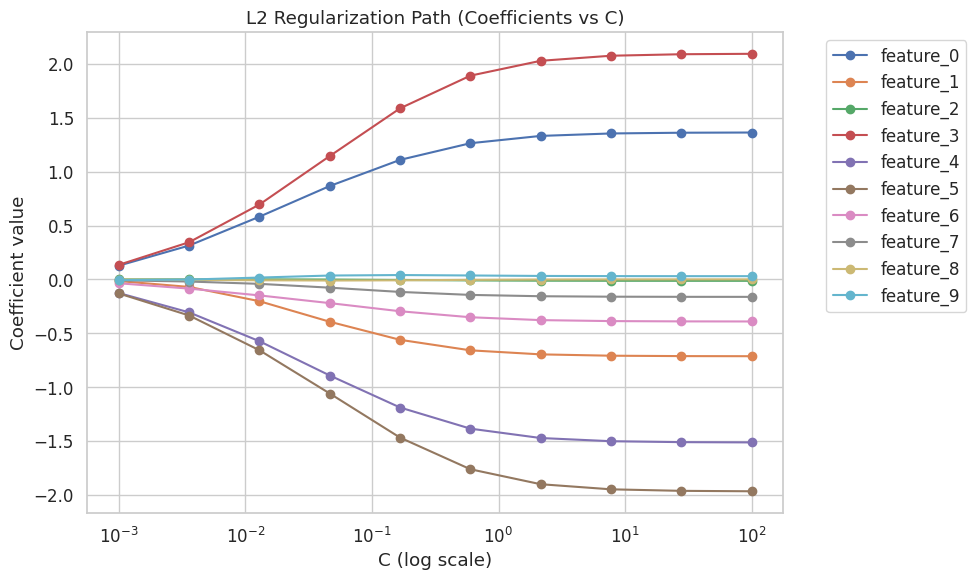

In [ ]:
plt.figure(figsize=(10, 6))
for j, name in enumerate(feature_names):
    plt.semilogx(C_values, l2_coefs[:, j], marker="o", label=name)

plt.xlabel("C (log scale)")
plt.ylabel("Coefficient value")
plt.title("L2 Regularization Path (Coefficients vs C)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


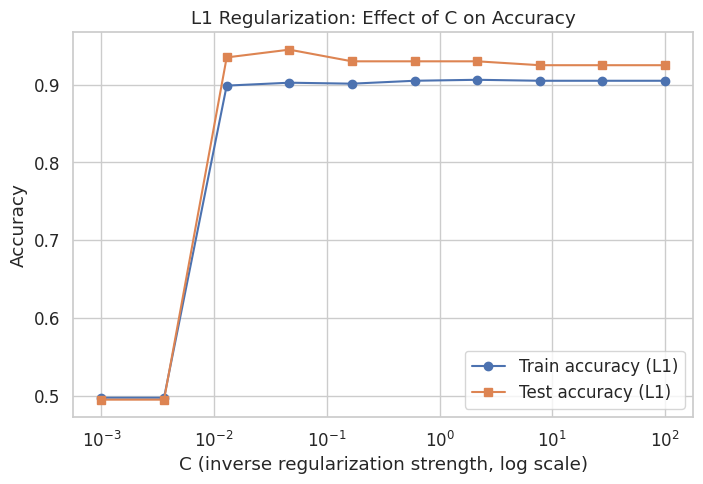

In [ ]:
C_values_l1 = np.logspace(-3, 2, 10)
l1_train_scores = []
l1_test_scores = []
l1_coefs = []

for C in C_values_l1:
    clf_l1 = LogisticRegression(
        penalty="l1",
        C=C,
        solver="liblinear",  # supports L1
        max_iter=1000,
        random_state=42,
    )
    clf_l1.fit(X_train_scaled, y_train)
    l1_train_scores.append(clf_l1.score(X_train_scaled, y_train))
    l1_test_scores.append(clf_l1.score(X_test_scaled, y_test))
    l1_coefs.append(clf_l1.coef_.ravel())

l1_coefs = np.array(l1_coefs)

plt.figure(figsize=(8, 5))
plt.semilogx(C_values_l1, l1_train_scores, marker="o", label="Train accuracy (L1)")
plt.semilogx(C_values_l1, l1_test_scores, marker="s", label="Test accuracy (L1)")
plt.xlabel("C (inverse regularization strength, log scale)")
plt.ylabel("Accuracy")
plt.title("L1 Regularization: Effect of C on Accuracy")
plt.legend()
plt.grid(True)
plt.show()


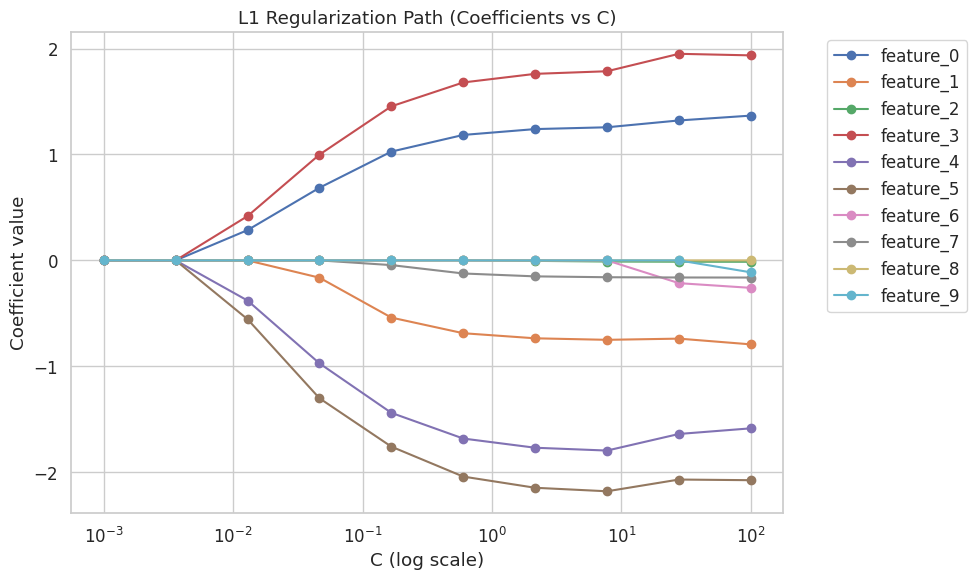

In [ ]:
plt.figure(figsize=(10, 6))
for j, name in enumerate(feature_names):
    plt.semilogx(C_values_l1, l1_coefs[:, j], marker="o", label=name)

plt.xlabel("C (log scale)")
plt.ylabel("Coefficient value")
plt.title("L1 Regularization Path (Coefficients vs C)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
C_compare = 0.1

clf_l2_c = LogisticRegression(
    penalty="l2",
    C=C_compare,
    solver="lbfgs",
    max_iter=1000,
    random_state=42,
)
clf_l2_c.fit(X_train_scaled, y_train)

clf_l1_c = LogisticRegression(
    penalty="l1",
    C=C_compare,
    solver="liblinear",
    max_iter=1000,
    random_state=42,
)
clf_l1_c.fit(X_train_scaled, y_train)

coefs_l2 = clf_l2_c.coef_.ravel()
coefs_l1 = clf_l1_c.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "L2_coef": coefs_l2,
    "L1_coef": coefs_l1,
})

coef_df


,feature,L2_coef,L1_coef
0,feature_0,1.021371,0.916684
1,feature_1,-0.501659,-0.427729
2,feature_2,-0.003545,0.000000
3,feature_3,1.421149,1.303009
4,feature_4,-1.078740,-1.277308
5,feature_5,-1.311569,-1.579565
6,feature_6,-0.266160,0.000000
7,feature_7,-0.100481,0.000000
8,feature_8,-0.009705,0.000000
9,feature_9,0.040583,0.000000


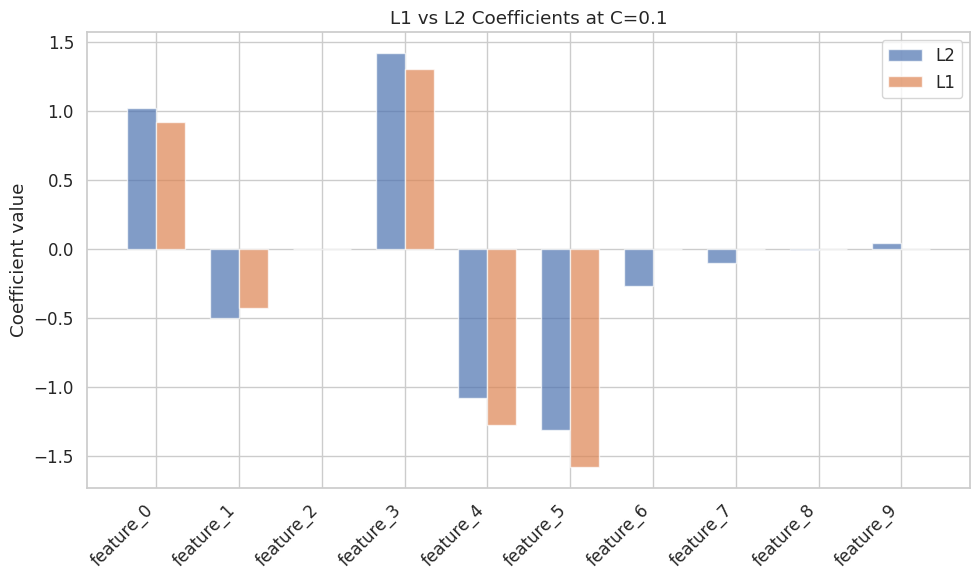

In [ ]:
x = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, coefs_l2, width, label="L2", alpha=0.7)
plt.bar(x + width/2, coefs_l1, width, label="L1", alpha=0.7)

plt.xticks(x, feature_names, rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title(f"L1 vs L2 Coefficients at C={C_compare}")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
comparison_df = pd.DataFrame({
    "C": C_values,
    "L2_train_acc": l2_train_scores,
    "L2_test_acc": l2_test_scores,
    "L1_train_acc": l1_train_scores,
    "L1_test_acc": l1_test_scores,
})

comparison_df


,C,L2_train_acc,L2_test_acc,L1_train_acc,L1_test_acc
0,0.001000,0.88375,0.915,0.49750,0.495
1,0.003594,0.89625,0.925,0.49750,0.495
2,0.012915,0.90000,0.930,0.89875,0.935
3,0.046416,0.90125,0.930,0.90250,0.945
4,0.166810,0.90750,0.930,0.90125,0.930
5,0.599484,0.90625,0.930,0.90500,0.930
6,2.154435,0.90500,0.925,0.90625,0.930
7,7.742637,0.90625,0.925,0.90500,0.925
8,27.825594,0.90500,0.925,0.90500,0.925
9,100.000000,0.90500,0.925,0.90500,0.925


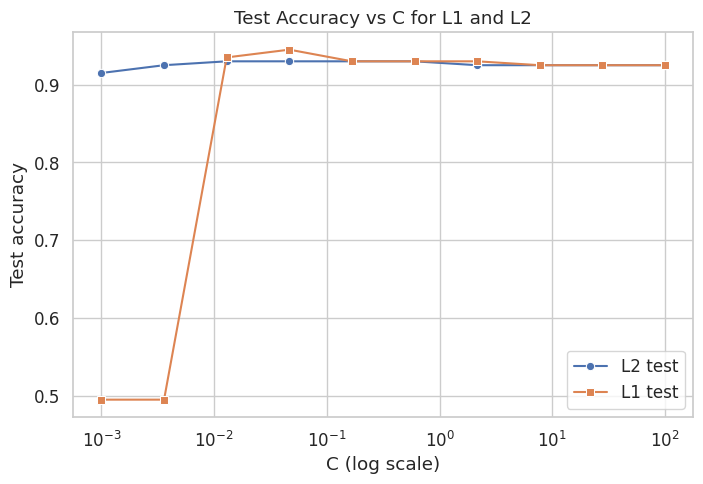

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=comparison_df, x="C", y="L2_test_acc", marker="o", label="L2 test")
sns.lineplot(data=comparison_df, x="C", y="L1_test_acc", marker="s", label="L1 test")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy vs C for L1 and L2")
plt.grid(True)
plt.show()


## Summary of Effects of L1 and L2 Regularization

- L2 regularization shrinks all coefficients smoothly as regularization strength increases
  (smaller C values), helping control overfitting without usually setting weights exactly to zero.
- L1 regularization can set some coefficients exactly to zero for strong regularization,
  effectively performing feature selection and producing sparse models.
- On this dataset, both penalties can achieve good test accuracy for a range of C values,
  but very small C underfits and very large C risks overfitting.
